# Sentiment Model with TensorFlow and Transformers

## Getting the Data

In [ ]:
!pip install kaggle
!pip install transformers

In [2]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"artemkel","key":"538e49db7e08967bd16401549e0fef8f"}'}

In [3]:
# put kaggle.json in the required directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# import libraries
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
import pandas as pd
import numpy as np
from transformers import BertTokenizer
import tensorflow as tf
from transformers import TFAutoModel

In [5]:
api = KaggleApi()
api.authenticate()

In [6]:
api.competition_download_file('sentiment-analysis-on-movie-reviews',
                              'test.tsv.zip', path='./')
api.competition_download_file('sentiment-analysis-on-movie-reviews',
                              'train.tsv.zip', path='./')

100%|██████████| 494k/494k [00:00<00:00, 1.55MB/s]


100%|██████████| 1.28M/1.28M [00:00<00:00, 3.25MB/s]

In [7]:
with zipfile.ZipFile('./test.tsv.zip') as zipref:
    zipref.extractall('./')

with zipfile.ZipFile('./train.tsv.zip') as zipref:
    zipref.extractall('./')

## Data Preprocessing

In [8]:
df = pd.read_csv('train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [9]:
# df.drop_duplicates(subset=['SentenceId'], keep='first')

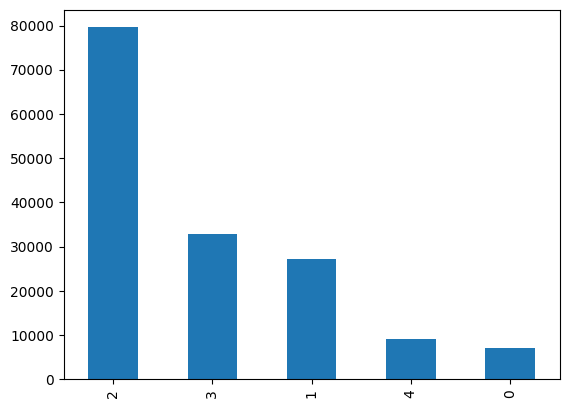

In [10]:
df['Sentiment'].value_counts().plot(kind='bar');

In [11]:
seq_len = 512
num_samples = len(df)

num_samples, seq_len

(156060, 512)

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [13]:
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len,
                   truncation=True, padding='max_length',
                   add_special_tokens=True,
                   return_tensors='np')

In [14]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [15]:
tokens['input_ids']

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]])

In [16]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [17]:
with open('movie-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])

with open('movie-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [18]:
arr = df.Sentiment.values

In [19]:
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(156060, 5)

In [20]:
labels[np.arange(num_samples), arr] = 1

In [21]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [22]:
with open('movie-labels.npy', 'wb') as f:
    np.save(f, labels)

## Set up Input Pipeline

In [23]:
with open('movie-xids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('movie-xmask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('movie-labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

In [24]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [25]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [26]:
def map_function(input_ids, masks, labels):
  return {'input_ids': input_ids,
          'attention_mask': masks}, labels

In [27]:
dataset = dataset.map(map_function)

In [28]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [29]:
batch_size = 16

In [30]:
dataset = dataset.shuffle(10_000).batch(batch_size, drop_remainder=True)

In [31]:
dataset.take(1) # batched tensors now

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [32]:
split = .9

In [33]:
size = int((Xids.shape[0] / batch_size) * split)

In [34]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [35]:
tf.data.Dataset.save(train_ds, 'train')
tf.data.Dataset.save(val_ds, 'val')

In [36]:
val_ds.element_spec == train_ds.element_spec

True

## Build and save the model

In [37]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [38]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108310272 (413.17 MB)
Trainable params: 108310272 (413.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
# two inputs
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# transformer
embeddings = bert.bert(input_ids, attention_mask=mask)[1]

# classifier head
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

In [40]:
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [41]:
model.layers[2].trainable = False

In [42]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                       

In [49]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-3)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [50]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
                 'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
                 tf.TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [51]:
train_ds = tf.data.Dataset.load('train', element_spec=element_spec)
val_ds = tf.data.Dataset.load('val', element_spec=element_spec)

In [52]:
train_ds.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

## Train the model

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

## Save the model

In [ ]:
model.save('sentiment_model')